In [1]:
pip install lpips

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 739.3 kB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [2]:
import lpips

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms

In [9]:
from tensorflow.keras.layers import concatenate

In [10]:
import PIL
from PIL import Image

In [11]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [12]:
from glob import glob

In [13]:
transform = transforms.Compose([
    transforms.ToTensor(),
#     transforms.Normalize((0.5),(0.5))
])

images = []
for image_file in glob("/kaggle/input/post-impression/*.jpg"):
    image = Image.open(image_file).convert('RGB')
    images.append(image)

In [14]:
len(images)

392

In [15]:
resized_img = []
for img in images:
    resized_img.append(img.resize((512,512)))

In [16]:
data = []
for image in resized_img:
    data.append(transform(image))

In [17]:
mini = 2
maxi = -2
for d in data:
    mini = min(mini, torch.min(d))
    maxi = max(maxi, torch.max(d))
print(mini, maxi)

tensor(0.) tensor(1.)


In [18]:
type(data[0])

torch.Tensor

In [19]:
data[0]

tensor([[[0.5686, 0.4118, 0.4510,  ..., 0.7059, 0.7020, 0.8314],
         [0.5020, 0.4627, 0.4627,  ..., 0.6980, 0.6706, 0.8078],
         [0.4824, 0.4353, 0.4549,  ..., 0.7137, 0.6745, 0.8157],
         ...,
         [0.5373, 0.6000, 0.4392,  ..., 0.6431, 0.7725, 0.8471],
         [0.5059, 0.6078, 0.4863,  ..., 0.7333, 0.7647, 0.8039],
         [0.5922, 0.5725, 0.4980,  ..., 0.7961, 0.7843, 0.7882]],

        [[0.4902, 0.3843, 0.4745,  ..., 0.7176, 0.7098, 0.8392],
         [0.4392, 0.4510, 0.4745,  ..., 0.7137, 0.6902, 0.8275],
         [0.4314, 0.4196, 0.4431,  ..., 0.7294, 0.6980, 0.8353],
         ...,
         [0.4784, 0.5451, 0.3882,  ..., 0.6078, 0.6980, 0.7294],
         [0.4667, 0.5412, 0.4000,  ..., 0.6980, 0.6980, 0.7098],
         [0.5569, 0.5098, 0.4118,  ..., 0.7490, 0.7137, 0.7020]],

        [[0.3176, 0.2314, 0.3137,  ..., 0.6314, 0.6314, 0.8039],
         [0.2667, 0.2706, 0.3137,  ..., 0.6275, 0.5922, 0.7373],
         [0.2510, 0.2275, 0.2824,  ..., 0.6431, 0.5961, 0.

In [20]:
import tensorflow_hub as hub
hub_model = hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2')

def style_transfer(content_image, style_image):
    stylized_image = hub_model(tf.constant(content_image), tf.constant(style_image))[0]
    stylized_image = stylized_image.numpy()
    return stylized_image

In [21]:
def tensor_to_image(tensor):
  tensor = tensor*255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor)

In [22]:
def load_img(path_to_img):
  max_dim = 512
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)

  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim

#   new_shape = tf.cast(shape * scale, tf.int32)

  img = tf.image.resize(img, (512,512))
  img = img[tf.newaxis, :]
  return img

In [23]:
def compute_scores(emb_one, emb_two, dim=2):
    scores = torch.nn.functional.cosine_similarity(emb_one, emb_two, dim=dim)
    return scores

In [97]:
def cloaking(original, styled, similarity_scores):
    cloaked = original.clone()
    for i in range(1,similarity_scores.shape[0]):
        for j in range(1,similarity_scores.shape[1]):
            if similarity_scores[i][j] > 0.35 and similarity_scores[i][j] < 0.4:
                cloaked[0][i][j] = styled[0][i][j]
    return cloaked

In [25]:
style_path = tf.keras.utils.get_file('cubism2.jpg','https://static01.nyt.com/images/2016/06/25/arts/25iht-reyburn25-a/25iht-reyburn25-a-jumbo.jpg')

193328/193328 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [26]:
style = load_img(style_path)

In [27]:
type(resized_img[0])

PIL.Image.Image

In [28]:
type(style)

tensorflow.python.framework.ops.EagerTensor

In [29]:
stylized = []
for img in resized_img:
    img = np.expand_dims(img, axis=0)
#     print('1')
    tensor_image = tf.convert_to_tensor(img, dtype=tf.float32)
#     print(type(tensor_image))
    new = style_transfer(tensor_image, style)
#     print('1')
    new = np.squeeze(new)
#     print('1')
    stylized.append(new)

In [30]:
stylized[0].shape

(512, 512, 3)

In [31]:
sty_data = []
for image in stylized:
    new = transform(image)
    new = new.unsqueeze(0)
    sty_data.append(new)

In [32]:
og_data = []
for image in data:
    new = image.unsqueeze(0)
    og_data.append(new)

In [33]:
type(sty_data[0])

torch.Tensor

In [34]:
og_data[0].shape

torch.Size([1, 3, 512, 512])

In [64]:
original_train = og_data[0:300]
stylized_train = sty_data[0:300]
original_test = og_data[300:392]
stylized_test = sty_data[300:392]

In [87]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ConvBlock(nn.Module):
    def __init__(self, input_filters, output_filters):
        super(ConvBlock, self).__init__()
        self.conv1 = nn.Conv2d(input_filters, output_filters, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(output_filters)
        self.conv2 = nn.Conv2d(output_filters, output_filters, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(output_filters)
        self.activation = nn.ReLU()

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.activation(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.activation(x)
        return x

class EncoderBlock(nn.Module):
    def __init__(self, input_filters, output_filters):
        super(EncoderBlock, self).__init__()
        self.conv_block = ConvBlock(input_filters, output_filters)
        self.pool = nn.MaxPool2d((2,2))

    def forward(self, x):
        x = self.conv_block(x)
        p = self.pool(x)
        return x, p

class DecoderBlock(nn.Module):
    def __init__(self, input_filters, output_filters):
        super(DecoderBlock, self).__init__()
        self.conv_transpose = nn.ConvTranspose2d(input_filters, output_filters, 2, stride=2)
        self.conv_block = ConvBlock(output_filters+output_filters, output_filters)

    def forward(self, x, skip_features):
        x = self.conv_transpose(x)
        x = torch.cat([x, skip_features], axis=1)
        x = self.conv_block(x)
        return x

class CloakBlock(nn.Module):
    def __init__(self):
        super(CloakBlock, self).__init__()

    def forward(self, original, styled):
        similarity_scores = compute_scores(original[0], styled[0])
        global og
        global st
        og = original
        st = styled
        cloaked = cloaking(original, styled, similarity_scores)
        return original

class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
#         self.input1 = nn.Conv2d(3, 64, 3, padding=1)
#         self.input2 = nn.Conv2d(3, 64, 3, padding=1)
        self.s1 = EncoderBlock(3,64)
        self.s2 = EncoderBlock(64,128)
        self.s3 = EncoderBlock(128,256)
        self.s4 = EncoderBlock(256,512)
        
        self.k1 = EncoderBlock(3,64)
        self.k2 = EncoderBlock(64,128)
        self.k3 = EncoderBlock(128,256)
        self.k4 = EncoderBlock(256,512)
        
        self.b1 = ConvBlock(512,1024)
        self.b2 = ConvBlock(512,1024)
        
        self.cloak_block = CloakBlock()
        self.d1 = DecoderBlock(1024,512)
        self.d2 = DecoderBlock(512,256)
        self.d3 = DecoderBlock(256,128)
        self.d4 = DecoderBlock(128,64)
        self.output = nn.Conv2d(64, 3, 1, padding=0)

    def forward(self, input1, input2):
        # Original image
        s1, p1 = self.s1(input1)
        s2, p2 = self.s2(p1)
        s3, p3 = self.s3(p2)
        s4, p4 = self.s4(p3)
        b1 = self.b1(p4)

        # Styled image
        k1, q1 = self.k1(input2)
        k2, q2 = self.k2(q1)
        k3, q3 = self.k3(q2)
        k4, q4 = self.k4(q3)
        b2 = self.b2(q4)

        # Cloaked features
        b3 = self.cloak_block(b1, b2)

        # Image reconstruction
        d1 = self.d1(b3, s4)
        d2 = self.d2(d1, s3)
        d3 = self.d3(d2, s2)
        d4 = self.d4(d3, s1)
        output = self.output(d4)
        return output

# # Define input shape
# input_shape = (3, 512, 512)

# # Create UNet model
# model = UNet()


In [98]:
model = UNet()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

In [67]:
print(torch.cuda.get_device_name(1))

Tesla T4


In [99]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
model.to(device)
original_train = [tensor.to(device) for tensor in original_train]
original_test = [tensor.to(device) for tensor in original_test]
stylized_train = [tensor.to(device) for tensor in stylized_train]
stylized_test = [tensor.to(device) for tensor in stylized_test]

In [100]:
num_epochs = 5
for epoch in range(num_epochs):
    model.train()  # Set the model to train mode
    running_loss = 0.0
    for i in range(len(original_train)):
        # Forward pass
        outputs = model(original_train[i], stylized_train[i])  # Assuming inputs is a tuple containing input1 and input2
        loss = criterion(outputs, original_train[i])  # Compute the loss

        # Backward pass and optimization
        optimizer.zero_grad()  # Zero the gradients
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights
        print("Done",i)
#         running_loss += loss.item() * inputs[0].size(0)  # Accumulate the loss

    # Print average loss for the epoch
#     epoch_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}")


Done 0
Done 1
Done 2
Done 3
Done 4
Done 5
Done 6
Done 7
Done 8
Done 9
Done 10
Done 11
Done 12
Done 13
Done 14
Done 15
Done 16
Done 17
Done 18
Done 19
Done 20
Done 21
Done 22
Done 23
Done 24
Done 25
Done 26
Done 27
Done 28
Done 29
Done 30
Done 31
Done 32
Done 33
Done 34
Done 35
Done 36
Done 37
Done 38
Done 39
Done 40
Done 41
Done 42
Done 43
Done 44
Done 45
Done 46
Done 47
Done 48
Done 49
Done 50
Done 51
Done 52
Done 53
Done 54
Done 55
Done 56
Done 57
Done 58
Done 59
Done 60
Done 61
Done 62
Done 63
Done 64
Done 65
Done 66
Done 67
Done 68
Done 69
Done 70
Done 71
Done 72
Done 73
Done 74
Done 75
Done 76
Done 77
Done 78
Done 79
Done 80
Done 81
Done 82
Done 83
Done 84
Done 85
Done 86
Done 87
Done 88
Done 89
Done 90
Done 91
Done 92
Done 93
Done 94
Done 95
Done 96
Done 97
Done 98
Done 99
Done 100
Done 101
Done 102
Done 103
Done 104
Done 105
Done 106
Done 107
Done 108
Done 109
Done 110
Done 111
Done 112
Done 113
Done 114
Done 115
Done 116
Done 117
Done 118
Done 119
Done 120
Done 121
Done 122
Don

In [78]:
og.shape

torch.Size([1, 1024, 32, 32])

In [78]:
type(og)

torch.Tensor

In [101]:
ImgTransform = transforms.ToPILImage()
output_img = model(original_test[0], stylized_test[0])
output_img = torch.squeeze(output_img)
output_img = ImgTransform(output_img)

In [102]:
sty_img = stylized_test[0]
sty_img = torch.squeeze(sty_img)
sty_img = ImgTransform(sty_img)

In [103]:
input_img = original_test[0]
input_img = torch.squeeze(input_img)
input_img = ImgTransform(input_img)

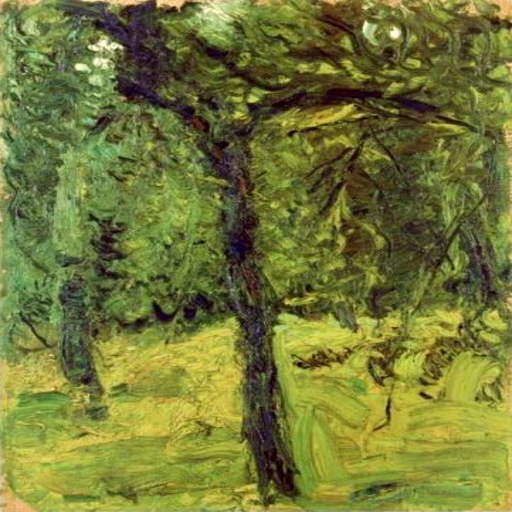

In [104]:
display(input_img)

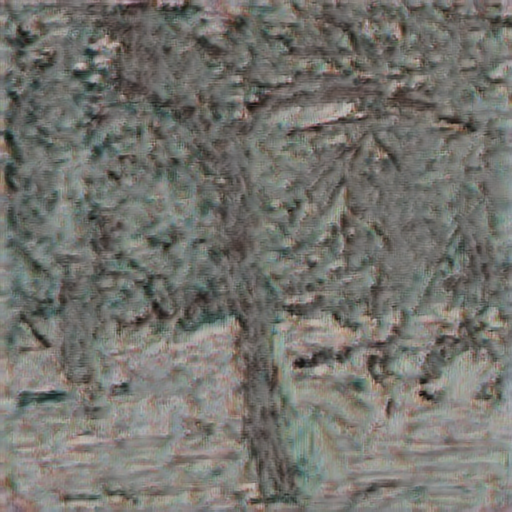

In [105]:
display(sty_img)

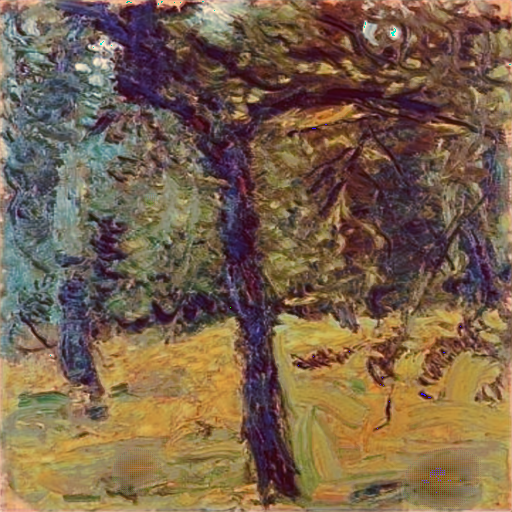

In [106]:
display(output_img)

Text(0.5, 1.0, 'Cloaked')

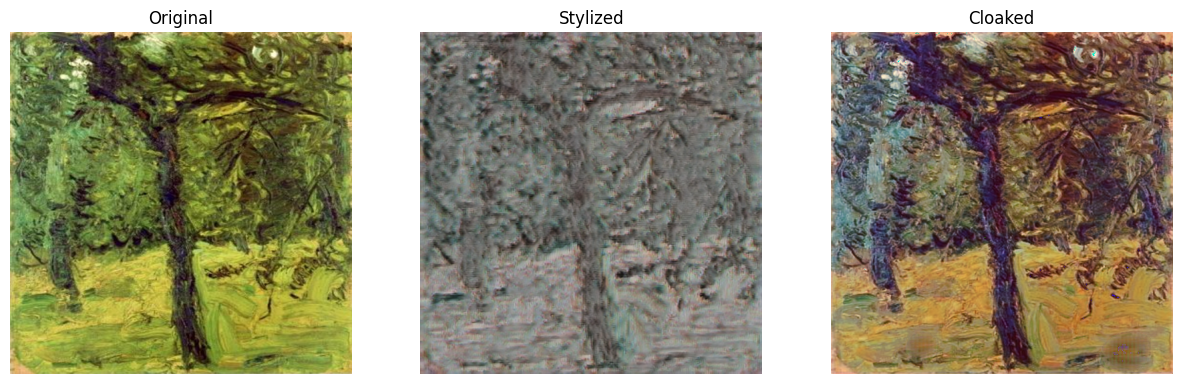

In [107]:
from matplotlib import pyplot as plt 
  
# create figure 
fig = plt.figure(figsize=(15, 10)) 
  
# setting values to rows and column variables 
rows = 1
columns = 3
  
fig.add_subplot(rows, columns, 1) 
  
# showing image 
plt.imshow(input_img) 
plt.axis('off') 
plt.title("Original") 
  
# Adds a subplot at the 2nd position 
fig.add_subplot(rows, columns, 2) 
  
# showing image 
plt.imshow(sty_img) 
plt.axis('off') 
plt.title("Stylized") 
  
# Adds a subplot at the 3rd position 
fig.add_subplot(rows, columns, 3) 
  
# showing image 
plt.imshow(output_img) 
plt.axis('off') 
plt.title("Cloaked") 

In [108]:
input_img.save('original.png')
output_img.save('cloaked.png')

In [114]:
img1 = Image.open('/kaggle/working/original.png').convert('RGB')
img2 = Image.open('/kaggle/working/cloaked.png').convert('RGB')
img2 = img2.resize(img1.size)

img1 = torch.tensor(np.array(img1)).permute(2,0,1).unsqueeze(0).float() / 127.5 - 1
img2 = torch.tensor(np.array(img2)).permute(2,0,1).unsqueeze(0).float() / 127.5 - 1

In [115]:
loss_fn = lpips.LPIPS(net='vgg')
d = loss_fn(img1, img2)

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


In [116]:
d

tensor([[[[0.3476]]]], grad_fn=<AddBackward0>)

## For cloaking function

In [41]:
og.shape

torch.Size([1, 1024, 32, 32])

In [53]:
og[0][0][0].shape

torch.Size([32])

In [81]:
similarity_scores = compute_scores(og[0], st[0], 2)
print(similarity_scores)

tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.1342, 0.3062],
        [0.1128, 0.2927, 0.8372,  ..., 0.5214, 0.1536, 0.0000],
        [0.0000, 0.9202, 0.1031,  ..., 0.1059, 0.0659, 0.0000],
        ...,
        [0.0000, 0.3552, 0.9810,  ..., 0.1540, 0.1741, 0.5958],
        [0.0456, 0.0000, 0.0000,  ..., 0.0149, 0.2603, 0.2984],
        [0.0946, 0.2665, 0.2854,  ..., 0.2385, 0.0799, 0.2011]],
       grad_fn=<SumBackward1>)


In [96]:
similarity_scores.shape

torch.Size([1024, 32])

In [126]:
og[0][1][1]

tensor([0.0000, 0.0000, 0.8493, 1.3134, 0.0558, 0.8479, 0.4316, 0.1172, 0.1979,
        0.2645, 0.0000, 0.5982, 0.5440, 0.0000, 0.4188, 0.0000, 0.9342, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0269, 0.0000, 0.0000, 0.0000, 0.0000, 0.6617,
        0.4043, 0.8224, 0.1484, 0.4077, 0.0000], grad_fn=<SelectBackward0>)

In [127]:
st[0][1][1]

tensor([1.5500, 1.8856, 0.4027, 0.6862, 0.1945, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0699, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.4201], grad_fn=<SelectBackward0>)

In [105]:
for i in range(0,similarity_scores.shape[0]):
    for j in range(0,similarity_scores.shape[1]):
        if similarity_scores[i][j] > 0.15 and similarity_scores[i][j] < 0.25:
            og[0][i][j] = st[0][i][j]

IndexError: list assignment index out of range

In [107]:
cl = og

In [113]:
og[0][0][0][0]

tensor(0.2000, grad_fn=<SelectBackward0>)

In [112]:
cl[0][0][0][0] = 0.2

In [163]:
compute_scores(og[0], og[0], 2)

tensor([[0.0000, 0.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
        ...,
        [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000]],
       grad_fn=<SumBackward1>)